In [1]:
from scipy.integrate import odeint
import time
import math
import numpy as np
from math import *
from scipy.optimize import newton
from matplotlib import animation, rc
from matplotlib import pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from IPython.display import HTML
import import_ipynb
import functions_meta_training
import warnings
import os


Configuration to choose the best hardware for optimal training efficiency


In [2]:
print(torch.cuda.is_available())  # Sollte True zurückgeben, wenn CUDA korrekt funktioniert.
print(torch.__version__)  # Zeigt die PyTorch-Version.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

False
2.5.1+cpu
cpu


Ignore redundant warnings

In [3]:
# Ignoriere alle UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", message="X does not have valid feature names")
warnings.filterwarnings("ignore", module="sklearn")

Initialize global default values for the process

In [4]:
g = 9.8                # gravitatioanl acceleration constant (m/s^2)
tfinal = 125.0 
Nt = 3755
t = np.linspace(0, tfinal, Nt)
timestep = tfinal / Nt

In [5]:
#This is the initial Condition Dennis Gannon trained his LSTM Network
# theta1 = -20
# theta2 = 35
theta1 = -20
theta2 = 35
amount_of_different_inits = 1
change_of_angle = 0
m1_params = [2]
m2_params = [1]
l1_params = [1.4]
l2_params = [1]

#this variable sets how strong the angle of the initial conditions should change in case you want differnet initials aswell
#if no initial change desired then set to 0
#Default value is always 1 to implement the condition you set by theta1 and theta2
# amount_of_different_inits = 1
# change_of_angle = 0
# m1_params = [2, 3]
# m2_params = [1, 2]
# l1_params = [1.4, 3]
# l2_params = [1]

# m1_params = [1, 2]
# m2_params = [2, 3]
# l1_params = [1]
# l2_params = [1.4, 3]

#multiple inits parameter study
# amount_of_different_inits = 7
# change_of_angle = 5
# m1_params = [2]
# m2_params = [1]
# l1_params = [1.4]
# l2_params = [1]

simulation_sets = functions_meta_training.multi_simulations(theta1, theta2, change_of_angle, amount_of_different_inits, Nt, tfinal, m1_params, m2_params, l1_params, l2_params, g)

Amount of chosen timesteps is 3755
Total simulation time is 125.0 s
theta 1 ist -20
theta 2 ist 35
m1 = 2; l1 = 1.4; m2 = 1; l2 = 1



Create the Training and Test data

In [6]:
print(len(simulation_sets))
scaler = MinMaxScaler(feature_range=(-1, 1))
train_datasets, test_datasets = functions_meta_training.data_splitter_and_scaler(scaler, simulation_sets, test_size = 0.2)

#1. Accesses the simulation with the params
#2. chooses the Batches
#3. Acesses the batches and you can choose between 1 (targed_batch / Labeled_batch) and 0 (training_batch)
print(train_datasets[0][0][1])

1
m1 = 2.0; l1 = 1.4; m2 = 1.0; l2 = 1.0; dt = 0.033288948069241014

tensor([[-0.4095,  0.8948,  0.1542, -0.7986,  2.0000,  1.0000,  1.4000,  1.0000,
          0.0333]])


This part below is for direct implementation in the code ?

In [7]:
class MyLSTM(nn.Module):
    def __init__(self, input_size=4, hidden_size=100, num_layers=1):

        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers)
        self.linear = nn.Linear(hidden_size, input_size)
        self.c_h = (
            torch.zeros(num_layers, 1, hidden_size),
            torch.zeros(num_layers, 1, hidden_size)
        )

    def forward(self, x):
        h, self.c_h = self.lstm(x.view(len(x), 1, -1), self.c_h)
        predictions = self.linear(h.view(len(x), -1))
        return predictions[-1]

    def freeze_layers(self, model, num_layers_to_freeze):
        layer_idx = 0
        for name, param in model.named_parameters():
            if "lstm" in name:
                if layer_idx < num_layers_to_freeze:
                    param.requires_grad = False
                else:
                    param.requires_grad = True
                layer_idx += 1

In [8]:
use_saved_model = False
filename = 'New'

input_size = 4
hidden_layer_size = 100
num_layers = len(train_datasets)

model_freeze = MyLSTM(input_size, hidden_layer_size, num_layers).to(device)


if use_saved_model == True:
    model_freeze.load_state_dict(torch.load(filename))
else:
    torch.save(model_freeze.state_dict(), filename)

In the following cell please define which type of Training you want run Options are:
##### Data Based 
##### Conservation of energy
##### Lagrange
defining which option to use intialize following variable 

In [20]:
#Choose wether physical informed or not ["Lagrange", "Energy", "Datadriven"]:
# training_type = "Lagrange"
# training_type = "Energy"
training_type = "Data_driven"

#Choose type of data handling during training, wether data should be taught structured or randomly
# data_handling = "random"
data_handling = "structured"

#Choose if you want to freeze layers during the training process
freeze = False

# Specify the amount of epochs for the training and how many subcycle each epoch should have
# epochs = 2002
# subcycle = 500
# Specify the amount of epochs for the training and how many subcycle each epoch should have
epochs = 100
subcycle = 50

In [ ]:
if use_saved_model == False:
    
    if training_type not in ["Lagrange", "Energy", "Data_driven"]:
        raise ValueError("Ungültiger training_type. Er muss 'Lagrange', 'Energy' oder 'Datadriven' sein.")
    
    if data_handling not in ["random", "structured"]:
        raise ValueError("Ungültiges Data handling. Es muss 'random'  oder 'structured' sein.")
    
    loss_function = nn.MSELoss()
    loss_function2 = nn.L1Loss()
    
    #Choosing the Optimizer
    optimizer_freeze = torch.optim.Adam(model_freeze.parameters(), lr=0.0005)
    
    # necessary for the documentation of the Trainingevolution
    total_loss_list = []
    physical_loss_list = []
    red_physical_loss_list = []
    data_loss_list = []
    test_error_mean_list = []
    test_error_MAE_list = []
    test_error_MSE_list = []
    trainingsequences = []
    counter = 0

    for j in range(0, len(train_datasets)):      
        if freeze == True:
            num_layers_to_freeze = j
            model_freeze.freeze_layers(model_freeze, j)
            if num_layers_to_freeze == 0:
                print(f'First training cycle is conducted without freezed layers: {num_layers_to_freeze}')
            else:
                print(f'Amount of freezed layers: {num_layers_to_freeze}')

        print(f"Cycle {j+1} of {len(train_datasets)} cycles has started")
        
        if data_handling == "structured":
            train_inout_seq = train_datasets[j]
        
        for i in range(epochs):
            counter += 1
            for _ in range(subcycle):
                
                if data_handling == "random":
                    #random call off the trainingdataset
                    random_call = np.random.randint(len(train_datasets))
                    train_inout_seq = train_datasets[random_call]
                
                #random call of the training batch
                num = np.random.randint(len(train_inout_seq))
                X_train = train_inout_seq[num][0][:,:4].to(device)
                y_target = train_inout_seq[num][1][:,:4].to(device)
                
                #get the last 4 pendulum-parameter
                params = train_inout_seq[num][0][:,4:].to(device)
                m1, m2, L1, L2, timestep = params[0]
                
                optimizer_freeze.zero_grad()

                model_freeze.c_h = (torch.zeros(len(train_datasets), 1, hidden_layer_size).to(device),
                                torch.zeros(len(train_datasets), 1, hidden_layer_size).to(device))

                y_pred_freeze = model_freeze(X_train)
                
                single_loss = loss_function(y_pred_freeze.view(1,4), y_target)
                
                #preparing the data for the physical loss
                #getting the previous timestep
                X_train_3D = torch.tensor(X_train, dtype=torch.float32).unsqueeze(0)

                prev_val = X_train_3D[0, -1, :]
                prev_val = prev_val.detach().cpu().numpy()
                prev_val_real = scaler.inverse_transform(prev_val.reshape(1, -1))

                #rescaling the actual prediction
                prediction_real = y_pred_freeze.detach().cpu().numpy()
                prediction_real = scaler.inverse_transform(prediction_real.reshape(1, -1))

                #for comparison the data target
                y_target_real = y_target.detach().cpu().numpy()
                y_target_real = scaler.inverse_transform(y_target_real.reshape(1, -1))

                if training_type == "Data_driven":
                    total_loss = single_loss
                elif training_type == "Energy":
                    energy_loss = functions_meta_training.conservation_of_energy(prediction_real, prev_val_real, y_target_real, m1, m2, L1, L2, g=9.81)
                    energy_loss = abs(energy_loss)
                    alpha = 0.1 + 0.9 * (i / epochs)
                    total_loss = single_loss + alpha * energy_loss
                elif training_type == "Lagrange":
                    lagrange_loss = functions_meta_training.lagrange_loss_single_value(prediction_real, prev_val_real, y_target_real, timestep, m1, m2, L1, L2)
                    alpha = 0.1 + 0.9 * (i / epochs)
                    total_loss = single_loss + alpha * lagrange_loss
                else:
                    raise ValueError("Ungültiger training_type. Er muss 'Lagrange', 'Energy' oder 'Datadriven' sein.")
                    
                total_loss.backward()
                optimizer_freeze.step()

                test_dataset_tensor = torch.tensor(test_datasets[j][:,:4])
                prediction, test_data, test_error_mean = functions_meta_training.training_tester(model_freeze, test_dataset_tensor, num_layers, device, hidden_layer_size)

                test_loss_MSE = loss_function(torch.tensor(test_data), torch.tensor(prediction))
                test_loss_MAE = loss_function2(torch.tensor(test_data), torch.tensor(prediction))

            if training_type == "Data_driven":
                not_considered = 0
                physical_loss_list.append(not_considered)
            elif training_type == "Energy":
                physical_loss_list.append(energy_loss.item())
            elif training_type == "Lagrange":
                physical_loss_list.append(lagrange_loss.item())    
            else:
                raise ValueError("Ungültiger training_type. Er muss 'Lagrange', 'Energy' oder 'Datadriven' sein.")      
                       
            total_loss_list.append(total_loss.item())
            data_loss_list.append(single_loss.item())
            test_error_mean_list.append(test_error_mean.item())
            test_error_MAE_list.append(test_loss_MAE.item())
            test_error_MSE_list.append(test_loss_MSE.item())

            trainingsequences.append(counter)

            if i%25 == 1:

                print(f'epoch: {i:3} data loss of freezed model: {single_loss.item():10.8f}')
                print(f'epoch: {i:3} total loss of freezed model: {total_loss.item():10.8f}')
                if training_type == "Energy":
                    print(f'epoch: {i:3} Energy loss of freezed model: {energy_loss.item():10.8f}')
                if training_type == "Lagrange":
                    print(f'epoch: {i:3} Lagrange loss of freezed model: {lagrange_loss.item():10.8f}')
                print(f'the test error ist {test_error_mean.item()}')
                # print(f'the test error ist {test_loss.item()}')

        df_losses = pd.DataFrame({
            "Epoch": trainingsequences,
            "Total Loss": total_loss_list,
            "Physical Loss": physical_loss_list,
            "Data Loss": data_loss_list,
            "Test Error Mean": test_error_mean_list,
            "Test Error Loss Function": test_error_MAE_list,
            "Test Error Loss Function MSE": test_error_MSE_list
        })

        # Path to download folder
        downloads_path = os.path.join(os.path.expanduser('~'), 'Downloads')
        
        # Save csv
        df_losses.to_csv(os.path.join(downloads_path, f"trainingloss_cycle{j+1}_{filename}.csv"), index=False)
        
        print(f"CSV-Datei gespeichert als 'trainingloss_cycle{j+1}_{filename}.csv'")

        # Create plot
        plt.figure(figsize=(10, 6))

        plt.plot(df_losses["Epoch"], df_losses["Total Loss"], label="Total Loss", color="blue")      
        plt.plot(df_losses["Epoch"], df_losses["Physical Loss"], label="Physical Loss", color="red")
        plt.plot(df_losses["Epoch"], df_losses["Data Loss"], label="Data Loss", color="orange")
        plt.plot(df_losses["Epoch"], df_losses["Test Error Mean"], label="Test Error Mean", color="green")  
        plt.plot(df_losses["Epoch"], df_losses["Test Error Loss Function"], label="Test Error Loss Function", color="purple") 
        plt.plot(df_losses["Epoch"], df_losses["Test Error Loss Function MSE"], label="Test Error Loss Function MSE", color="black")  

        #titles
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training Loss über die Epochen")
        plt.legend()
        plt.grid(True)

        plt.show()

        print(f"Period {j+1} was completed and the model states have been saved at this moment")
        torch.save(model_freeze.state_dict(), filename)
    print("training finished")
    
    torch.save(model_freeze.state_dict(), filename)
    

Testing

data set length = 751
751
0.3368080686522524 -2.2062297283982266


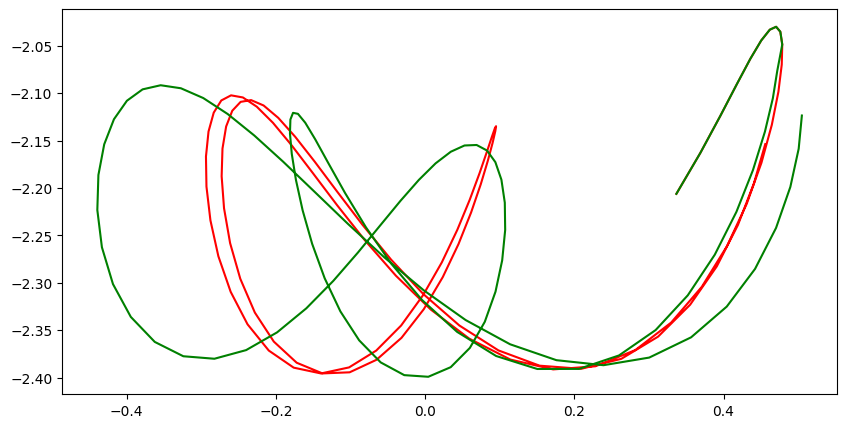

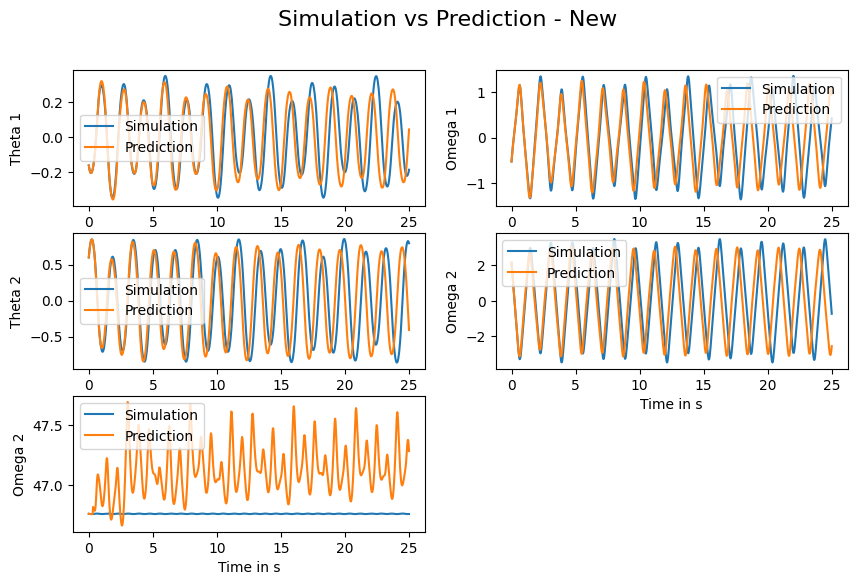

In [22]:
#path to directorry of destiny
filepath_excel = r'C:\Users\lauto\Downloads'
test_nr = 0
for test in test_datasets:
    test_nr += 1
    actual_predictions = functions_meta_training.OneStep(model_freeze, num_layers, test, filename, filepath_excel, test_nr, steps = 100, g = 9.81)

In case a second training under different conditions is required for finetuning

In [ ]:
second_training = False

In [ ]:
#Choose wether physical informed or not ["Lagrange", "Energy", "Datadriven"]:
# training_type = "Lagrange"
# training_type = "Energy"
training_type = "Data_driven"

#Choose type of data handling during training, wether data should be taught structured or randomly
# data_handling = "random"
data_handling = "structured"

#Choose if you want to freeze layers during the training process
freeze = False

# Specify the amount of epochs for the training and how many subcycle each epoch should have
# epochs = 2002
# subcycle = 500
# Specify the amount of epochs for the training and how many subcycle each epoch should have
epochs = 100
subcycle = 50

Here the second Training will be concucted the code is the same just in a function

In [ ]:
if second_training == False:
    filepath_excel = r'C:\Users\lauto\Downloads'

    functions_meta_training.model_trainer(model_freeze, scaler, train_datasets, test_datasets, epochs, subcycle, training_type, data_handling, freeze, filename, filepath_excel, device, num_layers, hidden_layer_size)   
